# Function Testing Notebook - Joseph

This notebook is meant to test external-facing functions to ensure they are working as expected.

A dedicated test_all_functions.py with unit testing might be better, but this is a good benchmark

In [1]:
import logging
import os
import sys
import tempfile
import time
from pathlib import Path

import matplotlib.colors as colors
import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
from dask.distributed import Client, LocalCluster
from dask_jobqueue import SLURMCluster

import matplotlib as mpl
import seaborn as sns
import seaborn.objects as so
from okabeito import black, blue, green, lightblue, orange, purple, red, yellow
from seaborn import axes_style


In [2]:
from pythoneeg import constants, core, visualization

/mnt/isilon/marsh_single_unit/PythonEEG/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
tempdir = Path('../../tmp').resolve()
print(tempdir)
core.set_temp_directory(tempdir)

/mnt/isilon/marsh_single_unit/PythonEEG/tmp


In [4]:
logging.basicConfig(format='%(asctime)s - %(levelname)s - %(message)s', level=logging.WARNING, stream=sys.stdout, force=True)
logger = logging.getLogger()

In [5]:
# df = pd.read_pickle("/mnt/isilon/marsh_single_unit/PythonEEG/notebooks/examples/alphadelta_avg_delta_alpha.pkl")
# df = pd.read_pickle("/mnt/isilon/marsh_single_unit/PythonEEG/notebooks/examples/alphadelta_avg_delta_alpha_minimally_filtered.pkl")
df = pd.read_pickle("/mnt/isilon/marsh_single_unit/PythonEEG/notebooks/examples/alphadelta_avg_delta_alpha_rms.pkl")
df

,animal,genotype,total_minutes,alphadelta,delta,alpha,logrms
0,"032221_cohort 2, Group 3, Mouse 6 Cage 2A Re-...",FHet,0.0,0.881516,7.757465,6.790708,4.599707
1,"032221_cohort 2, Group 3, Mouse 6 Cage 2A Re-...",FHet,60.0,0.826607,8.076053,6.618582,4.570048
2,"032221_cohort 2, Group 3, Mouse 6 Cage 2A Re-...",FHet,120.0,0.873190,7.805786,6.765110,4.592416
3,"032221_cohort 2, Group 3, Mouse 6 Cage 2A Re-...",FHet,180.0,0.826026,8.056613,6.596987,4.553007
4,"032221_cohort 2, Group 3, Mouse 6 Cage 2A Re-...",FHet,240.0,0.838690,7.849467,6.523342,4.516835
...,...,...,...,...,...,...,...
1319,090122_group4_2mice_FMut_MMut MMUT,MMut,1140.0,0.842792,7.825066,6.570612,4.543557
1320,090122_group4_2mice_FMut_MMut MMUT,MMut,1200.0,0.848149,8.018984,6.777836,4.582011
1321,090122_group4_2mice_FMut_MMut MMUT,MMut,1260.0,0.844169,7.904951,6.648846,4.561729
1322,090122_group4_2mice_FMut_MMut MMUT,MMut,1320.0,0.844334,8.005878,6.733367,4.564321


In [6]:
df = df.reset_index(drop=False)
df["sex"] = df["genotype"].str[0]
df["sex"] = df["sex"].map({"F": "Female", "M": "Male"})
df["genotype"] = df["genotype"].str[1:]
df['total_minutes'] = (df['total_minutes'] - 6 * 60) % 1440
for feature in ['alphadelta', 'delta', 'alpha', 'logrms']:
    df[f"{feature}_nobase"] = (
        df.groupby(["animal", "genotype", "sex"])
        .apply(lambda g: g[feature] - g.loc[(g["total_minutes"] <= 12 * 60), feature].mean())
        .reset_index(level=[0, 1, 2], drop=True)
    )
# Create a copy of df with shifted total_minutes
df2 = df.copy()
df2['total_minutes'] = df2['total_minutes'] + 1440

# Concatenate original and shifted dataframes
df = pd.concat([df, df2], ignore_index=True)

# Create genotype order mapping
genotype_order = {'WT': 0, 'Het': 1, 'Mut': 2}
df['genotype_order'] = df['genotype'].map(genotype_order)

# Create sex order mapping (Male first, then Female)
sex_order = {'Male': 0, 'Female': 1}
df['sex_order'] = df['sex'].map(sex_order)

# Sort by sex first, then genotype
df = df.sort_values(['sex_order', 'genotype_order'])

# Drop the temporary ordering columns
df = df.drop(['genotype_order', 'sex_order'], axis=1)


df

/tmp/ipykernel_924232/2500876437.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g[feature] - g.loc[(g["total_minutes"] <= 12 * 60), feature].mean())
/tmp/ipykernel_924232/2500876437.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g[feature] - g.loc[(g["total_minutes"] <= 12 * 60), feature].mean())
/tmp/ipykernel_924232/2500876437.py:9: FutureWarning: DataFrameGroupBy.apply o

,index,animal,genotype,total_minutes,alphadelta,delta,alpha,logrms,sex,alphadelta_nobase,delta_nobase,alpha_nobase,logrms_nobase
48,48,010822_cohort4_group2_2mice_MWT_MHET M10,WT,1080.0,0.710170,5.852663,4.304101,3.944173,Male,-0.058626,-1.001474,-1.003433,-0.255968
49,49,010822_cohort4_group2_2mice_MWT_MHET M10,WT,1140.0,0.717438,6.610708,4.818615,4.095445,Male,-0.051357,-0.243429,-0.488918,-0.104696
50,50,010822_cohort4_group2_2mice_MWT_MHET M10,WT,1200.0,0.696926,6.132890,4.410524,3.965317,Male,-0.071869,-0.721248,-0.897009,-0.234824
51,51,010822_cohort4_group2_2mice_MWT_MHET M10,WT,1260.0,0.744362,6.814298,5.085689,4.186148,Male,-0.024433,-0.039839,-0.221844,-0.013993
52,52,010822_cohort4_group2_2mice_MWT_MHET M10,WT,1320.0,0.774749,7.491779,5.688421,4.406924,Male,0.005954,0.637642,0.380888,0.206782
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2619,1295,090122_group4_2mice_FMut_MMut FMUT,Mut,2220.0,0.791413,7.698968,6.069978,4.480404,Female,-0.007208,-0.092530,-0.129643,0.044909
2620,1296,090122_group4_2mice_FMut_MMut FMUT,Mut,2280.0,0.777893,7.733464,6.000575,4.503751,Female,-0.020728,-0.058033,-0.199046,0.068256
2621,1297,090122_group4_2mice_FMut_MMut FMUT,Mut,2340.0,0.771923,7.751459,5.982364,4.454213,Female,-0.026698,-0.040038,-0.217257,0.018718
2622,1298,090122_group4_2mice_FMut_MMut FMUT,Mut,2400.0,0.788770,7.625869,6.008989,4.436931,Female,-0.009851,-0.165628,-0.190632,0.001436


In [7]:
# Get stats for number of unique animals by genotype and sex
animal_counts = df.groupby(['genotype', 'sex'])['animal'].nunique()
print("\nNumber of unique animals by genotype and sex:")
print(animal_counts)
print("\nTotal number of unique animals:", df['animal'].nunique())



Number of unique animals by genotype and sex:
genotype  sex   
Het       Female    11
          Male       9
Mut       Female    10
          Male      10
WT        Female     6
          Male      13
Name: animal, dtype: int64

Total number of unique animals: 59


In [8]:
feature_to_label = {
    'logrms' : "Log(RMS)",
    'alphadelta' : "Alpha/Delta ratio",
    'delta' : "Log Delta band power",
    'alpha' : "Log Alpha band power",
    'logrms_nobase' : "Log(RMS) - Baseline",
    'alphadelta_nobase' : "Alpha/Delta ratio - Baseline",
    'delta_nobase' : "Log Delta band power - Baseline",
    'alpha_nobase' : "Log Alpha band power - Baseline",
}

/mnt/isilon/marsh_single_unit/PythonEEG/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


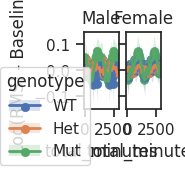

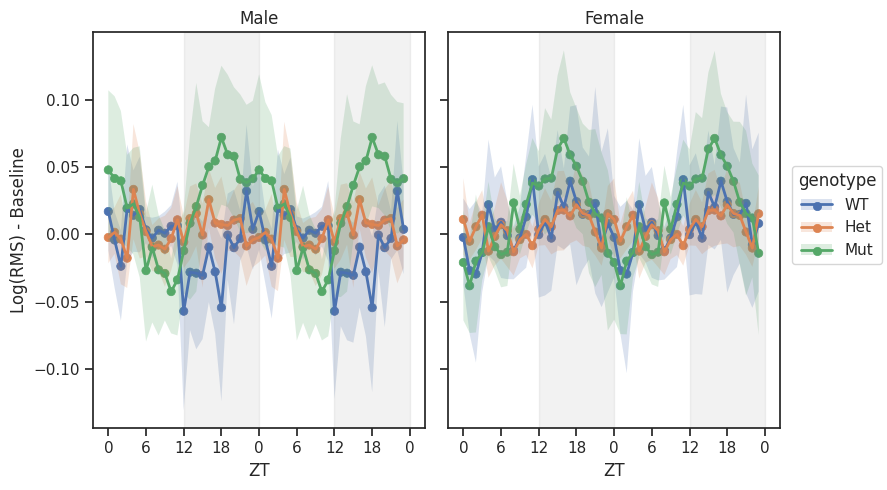

/mnt/isilon/marsh_single_unit/PythonEEG/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


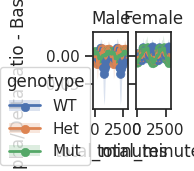

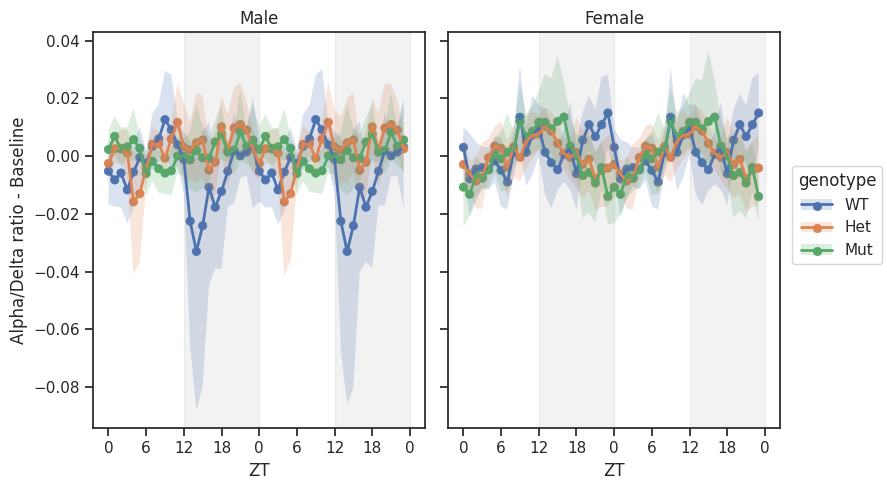

/mnt/isilon/marsh_single_unit/PythonEEG/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


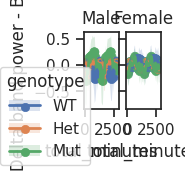

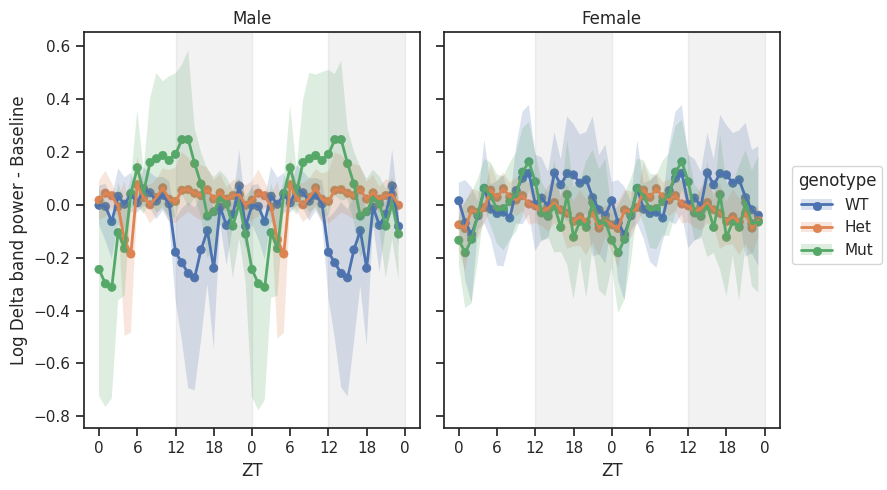

/mnt/isilon/marsh_single_unit/PythonEEG/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


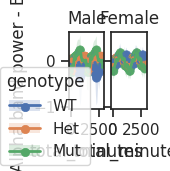

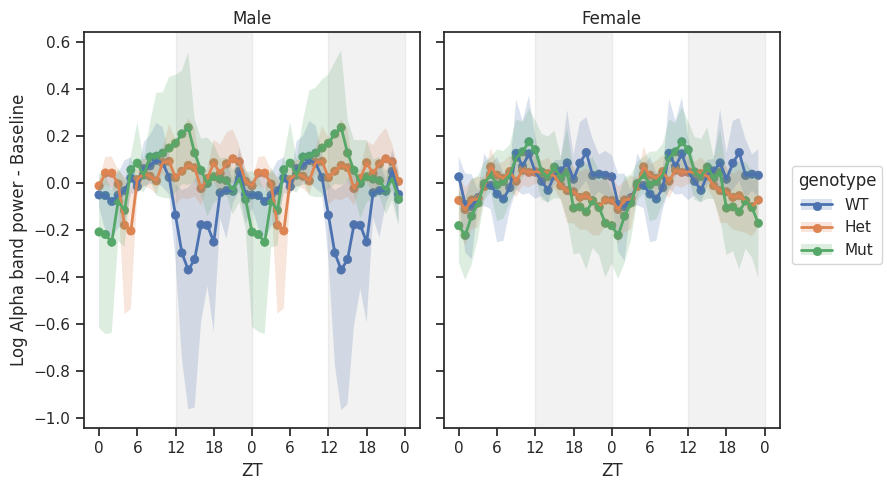

/mnt/isilon/marsh_single_unit/PythonEEG/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


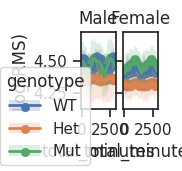

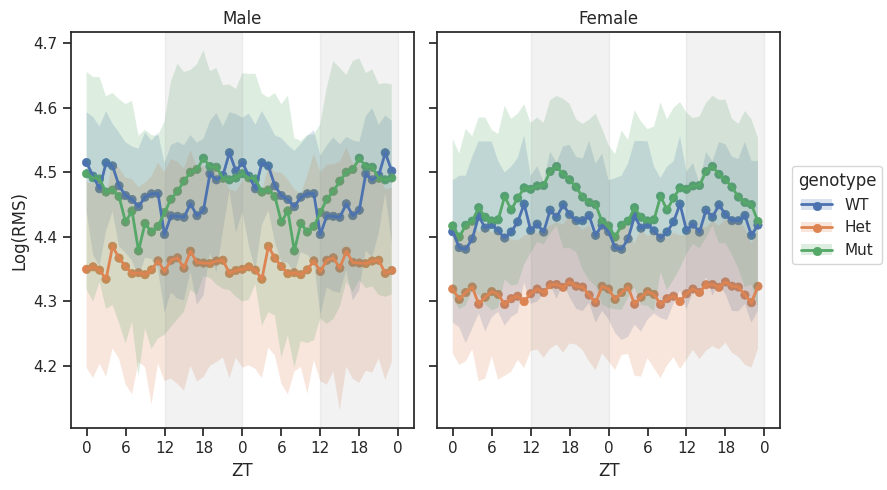

/mnt/isilon/marsh_single_unit/PythonEEG/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


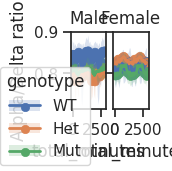

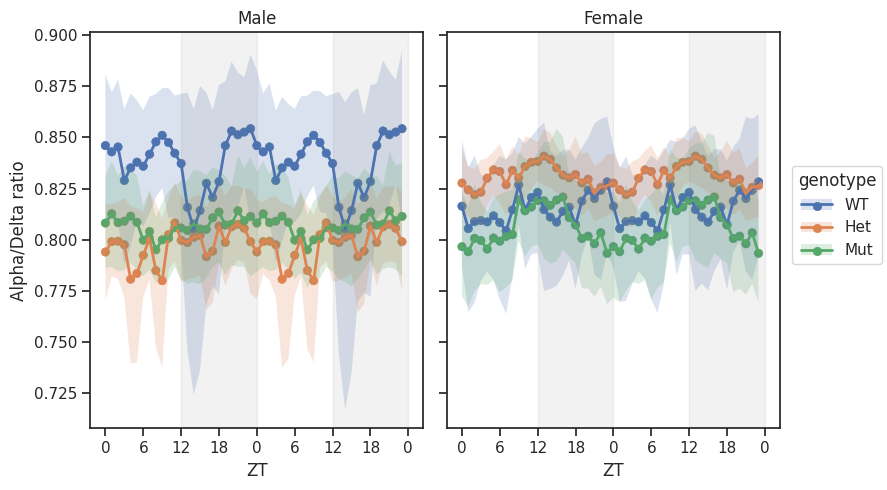

/mnt/isilon/marsh_single_unit/PythonEEG/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


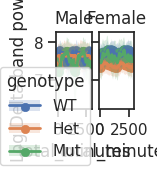

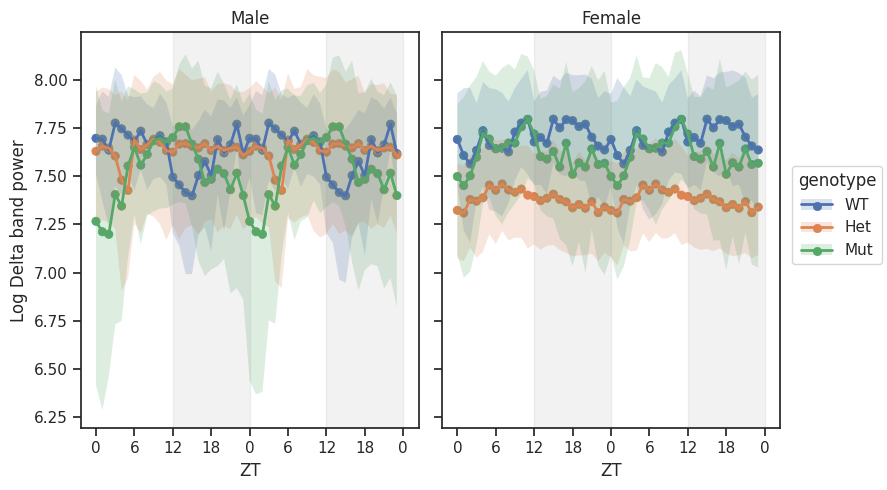

/mnt/isilon/marsh_single_unit/PythonEEG/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


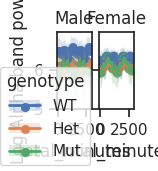

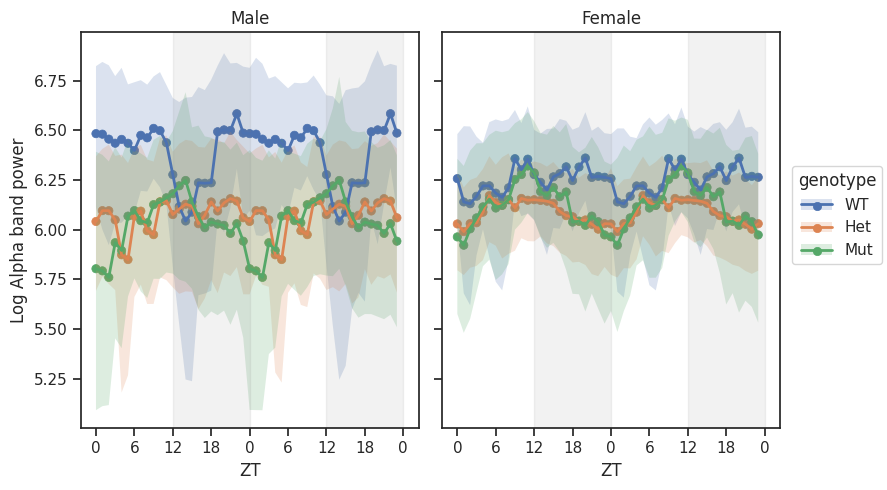

In [11]:
import matplotlib as mpl

features = ['logrms_nobase', 'alphadelta_nobase', 'delta_nobase', 'alpha_nobase', 'logrms', 'alphadelta', 'delta', 'alpha']

for i, feature in enumerate(features):
    p = (  # fmt: off
        so.Plot(df, x="total_minutes", y=feature, color='genotype')  # fmt: off
        .facet(col='sex')
        .add(so.Line(linewidth=2), so.Agg())
        .add(so.Dot(), so.Agg())
        .add(so.Band(), so.Est())
        # .add(so.Lines(linewidth=1, alpha=0.8), group='animal')
        # .add(
        #         so.Text(valign="center", fontsize=5),
        #         so.Agg(),
        #         text="animal",
        #     )
        .layout(size=(1, 1)) 
        .theme(axes_style("ticks"))
        .label(y=feature_to_label[feature])
    )
    # fig = mpl.figure.Figure(figsize=(20, 15))
    fig = mpl.figure.Figure(figsize=(8, 5))
    p.show()
    p.on(fig).plot()
    for ax in fig.axes:
        # ax.axvspan(xmin=0, xmax=6 * 60, alpha=0.1, color='grey')
        ax.axvspan(xmin=12 * 60, xmax=24 * 60, alpha=0.1, color='grey')
        ax.axvspan(xmin=36 * 60, xmax=48 * 60, alpha=0.1, color='grey')

        # Set ticks every 12 hours (12 * 60 minutes)
        ax.set_xticks(np.arange(0, 49 * 60, 6 * 60))
        new_labels = [(x/60) % 24 for x in ax.get_xticks()]
        ax.set_xticklabels([f"{x:.0f}" for x in new_labels])
        ax.set_xlabel("ZT")

    fig.tight_layout()
    display(fig)
    # fig.savefig(f"/home/dongjp/Downloads/7-20 vstime/{i}_{feature}.png")
    plt.close()
